In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("survival_data.csv")
df['censored'] = 1-df.broken
df = df.sort_values('lifetime')
df.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider,censored
52,1,0,72.423129,120.484155,116.400433,TeamB,Provider2,1
205,1,0,92.100802,89.994611,97.292290,TeamB,Provider1,1
464,1,0,141.042595,113.358822,91.310554,TeamC,Provider2,1
71,1,0,107.785993,117.390336,113.377308,TeamB,Provider4,1
209,1,0,104.658530,107.537666,126.374317,TeamB,Provider1,1


In [4]:
km_estimator = pd.DataFrame(columns = ['lifetime', 'broken', 'censored', 'n_sample', 'HF', 'cHF', 'survival'])
km_estimator.lifetime = df.lifetime.unique()

n = len(df)
cHF = 0
survival = 1
ind = 0
for t in km_estimator.lifetime:
    df_filter = df.loc[df.lifetime == t]
    km_estimator.loc[ind, 'broken'] = df_filter['broken'].sum()
    km_estimator.loc[ind, 'censored'] = df_filter['censored'].sum()
    
    
    km_estimator.n_sample[ind] = n
    n -= (df_filter['broken'].sum() + df_filter['censored'].sum())
    
    km_estimator.HF[ind] = km_estimator.broken[ind]/km_estimator.n_sample[ind]
    
    cHF += km_estimator.HF[ind]
    km_estimator.cHF[ind] = cHF
    
    survival *= (1-km_estimator.HF[ind])
    km_estimator.survival[ind] = survival
    
    ind += 1
    
    
km_estimator

,lifetime,broken,censored,n_sample,HF,cHF,survival
0,1,0,5,1000,0.0,0.0,1.0
1,2,0,11,995,0.0,0.0,1.0
2,3,0,3,984,0.0,0.0,1.0
3,4,0,8,981,0.0,0.0,1.0
4,5,0,10,973,0.0,0.0,1.0
...,...,...,...,...,...,...,...
85,88,42,4,112,0.375,1.410894,0.204093
86,89,1,0,66,0.015152,1.426045,0.201001
87,90,0,1,65,0.0,1.426045,0.201001
88,92,32,0,64,0.5,1.926045,0.1005


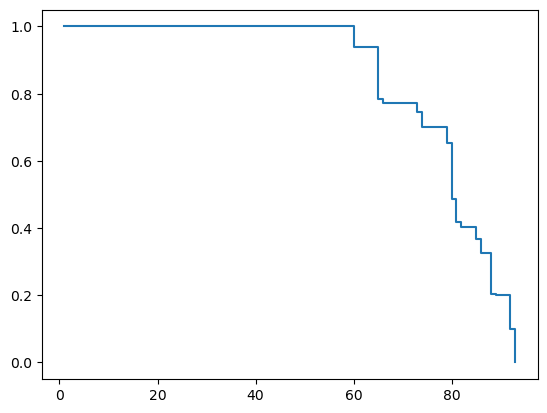

In [5]:
plt.plot(km_estimator.lifetime, km_estimator.survival, drawstyle = 'steps-post')

In [6]:
from lifelines import KaplanMeierFitter
km_fitter = KaplanMeierFitter()
km_fitter.fit(df.lifetime, df.broken)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1000 total observations, 603 right-censored observations>

<Axes: xlabel='timeline'>

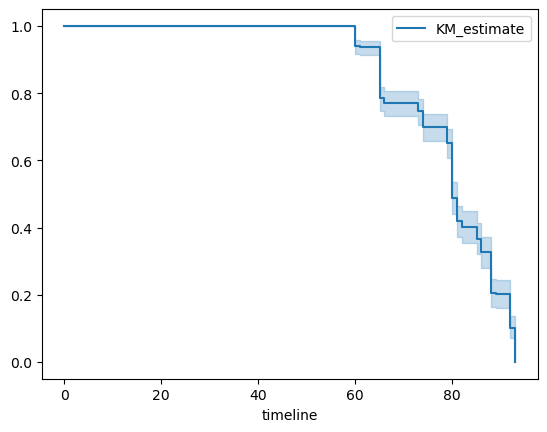

In [7]:
km_fitter.plot(ci_show=True)
# plt.plot(km_estimator.lifetime, km_estimator.survival, drawstyle = 'steps-post')

In [8]:
from lifelines import CoxPHFitter

In [9]:
df = pd.read_csv("survival_data.csv")
df = pd.get_dummies(df, drop_first = True)

df = df.drop(['pressureInd', 'moistureInd', 'team_TeamB'], axis = 'columns')
df

,lifetime,broken,temperatureInd,team_TeamC,provider_Provider2,provider_Provider3,provider_Provider4
0,56,0,96.517159,False,False,False,True
1,81,1,87.271062,True,False,False,True
2,60,0,112.196170,False,False,False,False
3,86,1,72.025374,True,True,False,False
4,34,0,103.756271,False,False,False,False
...,...,...,...,...,...,...,...
995,88,1,99.861456,False,False,False,True
996,88,1,95.075631,False,False,False,True
997,22,0,83.221220,False,False,False,False
998,78,0,83.421491,False,False,False,True


In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)

In [11]:
cph = CoxPHFitter()
cph.fit(train, duration_col='lifetime', event_col='broken')

<lifelines.CoxPHFitter: fitted with 700 total observations, 432 right-censored observations>

In [12]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 700 total observations, 432 right-censored observations>
             duration col = 'lifetime'
                event col = 'broken'
      baseline estimation = breslow
   number of observations = 700
number of events observed = 268
   partial log-likelihood = -702.63
         time fit was run = 2023-12-01 11:07:14 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
temperatureInd       0.03       1.03       0.00             0.02             0.03                 1.02                 1.03
team_TeamC          43.68   9.30e+18    4629.06         -9029.12          9116.48                 0.00                  inf
provider_Provider2 -87.50       0.00    8327.57        -16409.25         16234.24                 0.00                  inf
provider_Provider3  68.85   7.98e+29   20525.86        -40161.10         40298.81                 0.00                  inf
provider_Provider4 -65.44       0.00    6617.53        -13035.57         12904.69                 0.00                  inf

                     cmp to     z      p   -log2(p)
covariate                                          
temperatureInd         0.00  7.00 <0.005      38.52
team_TeamC             0.00  0.01   0.99       0.01
provider_Provider2     0.00 -0.01   0.99       0.01
provider_Provider3     0.00  0.00   1.00       0.00
provider_Provider4     0.00 -0.01   0.99       0.01
---
Concordance = 1.00
Partial AIC = 1415.26
log-likelihood ratio test = 1133.99 on 5 df
-log2(p) of ll-ratio test = 804.69

In [13]:
cph.predict_expectation(test)

952    86.795882
332    87.442355
666    65.385779
395    78.496046
2      78.496397
         ...    
560    83.824889
840    71.898608
739    87.387812
789    64.563144
233    90.995095
Length: 300, dtype: float64

<Axes: xlabel='log(HR) (95% CI)'>

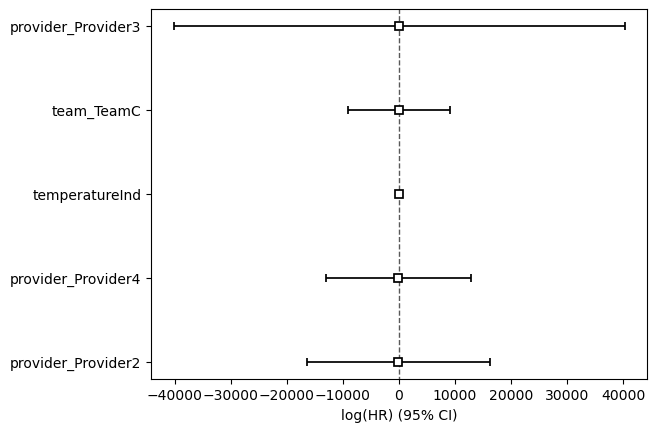

In [14]:
cph.plot()

In [15]:
test_broken = test[test.broken == 1]
ypred = cph.predict_expectation(test_broken)
ypred.head()

446    90.420031
396    85.064156
41     64.425576
917    59.169728
993    63.829796
dtype: float64

Text(0, 0.5, 'Predictions')

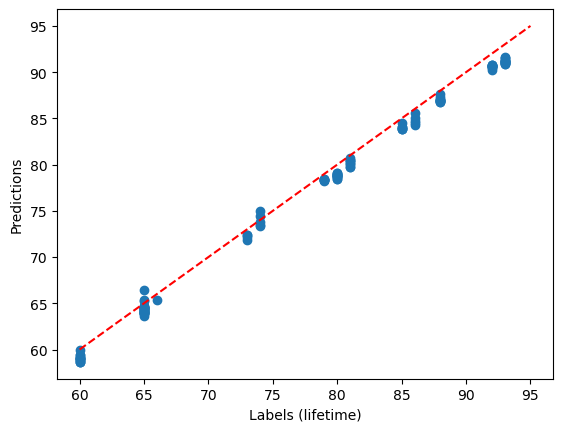

In [16]:
plt.scatter(test_broken.lifetime, ypred)
plt.plot([60, 95], [60, 95], 'r--')
plt.xlabel('Labels (lifetime)')
plt.ylabel('Predictions')

<Axes: >

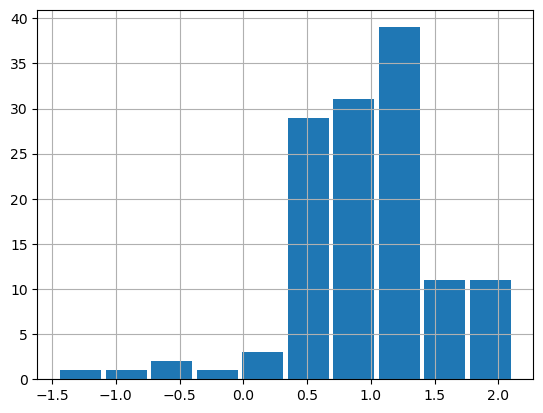

In [17]:
error = test_broken.lifetime - ypred
error.hist(rwidth=0.9)